# Importing the Required Modules

In [5]:
import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# Reading the Image Paths and Preparing the CSV File

Explaining the Below Code:

Line 1 gets all the image paths as a list and stores them in image_paths.

At line 6, we create an empty DataFrame where we will save all the image paths and the labels.

At line 7, we create an empty list named labels. Then starting from line 8, we read all the image paths and save them under the image_path column in the data DataFrame. Also, at line 12, we append all the labels to the labels list.


In [16]:
image_paths = list(paths.list_images('/root/shared/CNS/Image classification/train/'))
test_paths= list(paths.list_images('/root/shared/CNS/Image classification/test/'))
# create an empty DataFrame
data = pd.DataFrame()

labels = []
#organ_system=[]
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    labels.append(label)
    #print(label)

100%|██████████| 1160/1160 [00:00<00:00, 2444.80it/s]


Line 1 converts the labels into an array. Then at line 4, we one-hot encode the labels. After one-hot encoding, for each instance, we will have an array of 12 elements. These 12 elements will correspond to the 12 categories in the dataset. But only the corresponding element will be 1 and all the other 11 will be 0.

In [17]:
labels = np.array(labels)
#labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#organ_system=np.array(organ_system)

In [18]:
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping an one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")


The first one hot encoded labels: [1 0 0 0 0 0 0 0 0 0 0 0]
Mapping an one hot encoded label to its category: colon
Total instances: 1160


In [19]:
for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)


In [20]:
data = data.sample(frac=1).reset_index(drop=True)
# save as csv file
data.to_csv('/root/shared/CNS/Image classification/data.csv', index=False)
# pickle the label binarizer
joblib.dump(lb, '/root/shared/CNS/lb.pkl')
print('Save the one-hot encoded binarized labels as a pickled file.')
print(data)

Save the one-hot encoded binarized labels as a pickled file.
                                             image_path  target
0     /root/shared/CNS/Image classification/train/pa...     7.0
1     /root/shared/CNS/Image classification/train/sp...    11.0
2     /root/shared/CNS/Image classification/train/lu...     5.0
3     /root/shared/CNS/Image classification/train/co...     0.0
4     /root/shared/CNS/Image classification/train/sk...     9.0
...                                                 ...     ...
1155  /root/shared/CNS/Image classification/train/sm...    10.0
1156  /root/shared/CNS/Image classification/train/sp...    11.0
1157  /root/shared/CNS/Image classification/train/sp...    11.0
1158  /root/shared/CNS/Image classification/train/sk...     8.0
1159  /root/shared/CNS/Image classification/train/sp...    11.0

[1160 rows x 2 columns]


# Writing the Neural Network Training Code

## Importing Required Libraries

In [21]:
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision

## Seeding for Reproducibility

In [22]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cpu


# Preparing Dataset and Data Loaders

## Reading CSV File

In [31]:
df = pd.read_csv('/root/shared/CNS/Image classification/data.csv')
X = df.image_path.values
y = df.target.values

# Creating the Dataset Module

In [32]:
class NaturalImageDataset(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=1.0),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=30,
                    p=1.0
                ),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        #print(torch.tensor(image, dtype=torch.float),torch.tensor(label, dtype=torch.long))
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

## Train Test Split

In [33]:
xtrain, xval, ytrain, yval = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))

xtrain.shape

(870,)

## Creating the Iterable Data Loaders

In [34]:
train_data = NaturalImageDataset(xtrain, ytrain, tfms=1)
val_data = NaturalImageDataset(xval, yval, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
valloader = DataLoader(val_data, batch_size=32, shuffle=False)



## Just Experimenting

In [35]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images[0].shape)

torch.Size([3, 224, 224])


## Plotting Train Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


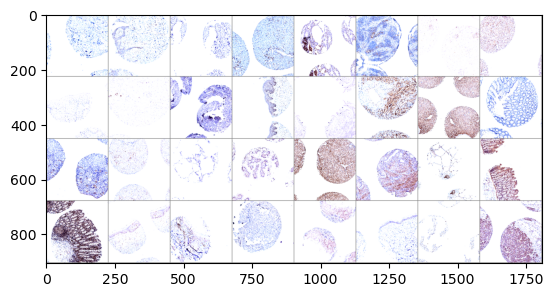

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Preparing the Neural Network Model and Loading the Binarized Labels 

In [28]:
print('Loading label binarizer...')
lb = joblib.load('/root/shared/CNS/lb.pkl')

Loading label binarizer...


## ResNet50

 I created this model because i was just curious about its structure of hidden layers.

### Training Phase

In [49]:
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model.fc = nn.Linear(2048, len(lb.classes_))
    return model
model = model(pretrained=True, requires_grad=False).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Defining the optimizer and the criterion for our neural network model

In [54]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

#### Train and Validation Functions

In [55]:
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [56]:
#validation function
def validate(model, val_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_dataloader), total=int(len(val_data)/val_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(val_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(val_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

#### Executing the Training and Validation Functions

In [57]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    print(f"Epoch {epoch+1} of 10")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1 of 10
Training


28it [08:02, 17.25s/it]                        


Train Loss: 0.0765, Train Acc: 18.74
Validating


10it [02:39, 15.99s/it]                      


Val Loss: 0.0768, Val Acc: 29.31
Epoch 2 of 10
Training


28it [08:06, 17.37s/it]                        


Train Loss: 0.0664, Train Acc: 42.53
Validating


10it [02:35, 15.57s/it]                      


Val Loss: 0.0637, Val Acc: 51.72
Epoch 3 of 10
Training


28it [08:08, 17.45s/it]                        


Train Loss: 0.0569, Train Acc: 57.70
Validating


10it [02:38, 15.82s/it]                      


Val Loss: 0.0555, Val Acc: 56.90
Epoch 4 of 10
Training


28it [08:03, 17.27s/it]                        


Train Loss: 0.0513, Train Acc: 60.92
Validating


10it [02:39, 15.95s/it]                      


Val Loss: 0.0510, Val Acc: 57.24
Epoch 5 of 10
Training


28it [08:20, 17.88s/it]                        


Train Loss: 0.0469, Train Acc: 62.30
Validating


10it [02:45, 16.50s/it]                      


Val Loss: 0.0482, Val Acc: 56.90
Epoch 6 of 10
Training


28it [08:00, 17.14s/it]                        


Train Loss: 0.0445, Train Acc: 64.60
Validating


10it [02:37, 15.74s/it]                      


Val Loss: 0.0446, Val Acc: 60.00
Epoch 7 of 10
Training


28it [08:26, 18.08s/it]                        


Train Loss: 0.0408, Train Acc: 66.55
Validating


10it [02:40, 16.04s/it]                      


Val Loss: 0.0433, Val Acc: 60.69
Epoch 8 of 10
Training


28it [08:22, 17.95s/it]                        


Train Loss: 0.0394, Train Acc: 67.13
Validating


10it [02:49, 16.94s/it]                      


Val Loss: 0.0400, Val Acc: 65.17
Epoch 9 of 10
Training


28it [08:25, 18.06s/it]                        


Train Loss: 0.0383, Train Acc: 67.24
Validating


10it [02:53, 17.32s/it]                      


Val Loss: 0.0400, Val Acc: 63.10
Epoch 10 of 10
Training


28it [08:11, 17.55s/it]                        


Train Loss: 0.0363, Train Acc: 68.97
Validating


10it [02:41, 16.20s/it]                      

Val Loss: 0.0368, Val Acc: 66.90
109.145 minutes


#### Plotting Accuracies

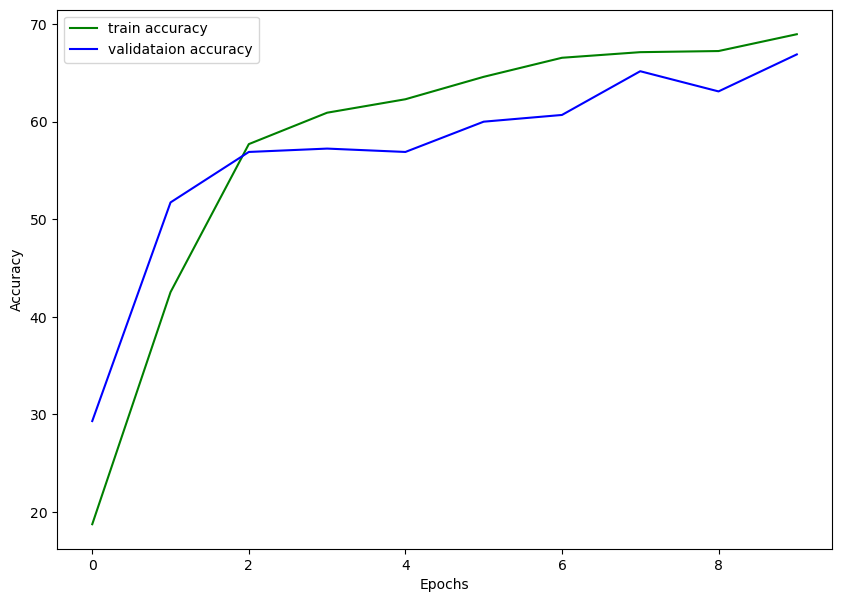

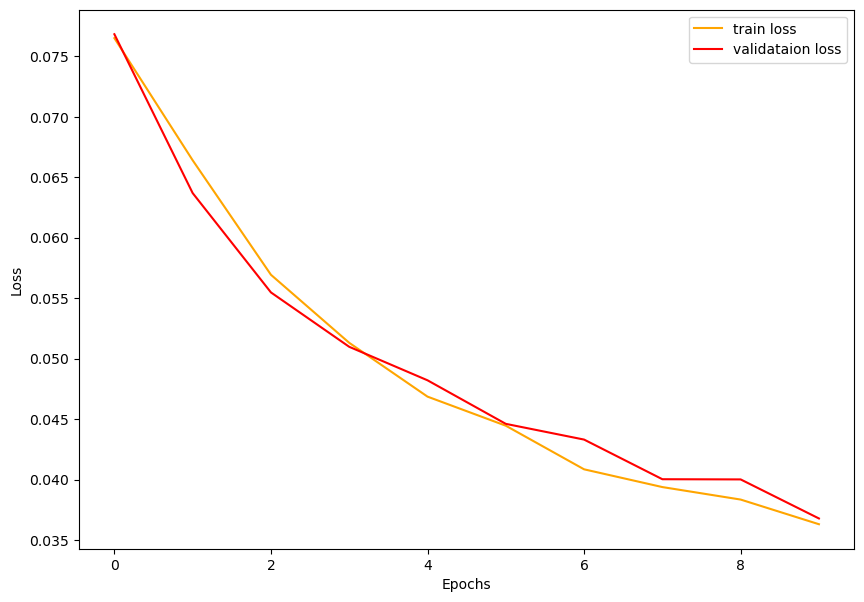

In [58]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('../outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('../outputs/loss.png')
plt.show()

### Saving Model for Reuse 
My kernel keeps crashing so i found this to be a safe way to keep my progress intact

In [59]:
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '/root/shared/CNS/model.pth')

Saving model...


### Testing Phase

In [16]:
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2 as cv
import argparse
from torchvision import models

In [17]:
# load label binarizer
lb = joblib.load('/root/shared/CNS/lb.pkl')

In [18]:
'''MODEL'''
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layers learnable
    model.fc = nn.Linear(2048, len(lb.classes_))
    return model
model = model(pretrained=False, requires_grad=False)
model.load_state_dict(torch.load('/root/shared/CNS/model.pth'))
print('Model loaded')

Model loaded


#### Reading the Image and Predicting the Output

Our ResNet model didn't do a good job but i intend on retraining the model on entire training data and then testing it on entire test data 

True
torch.Size([1, 3, 3000, 3000])
Predicted output: small_intestine


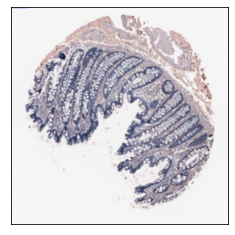

In [19]:
from os.path import exists

file_exists = exists('/root/shared/CNS/Image classification/test/colon/40043_94144_A_7_3.tif')
print(file_exists)

image = cv.imread(f"/root/shared/CNS/Image classification/test/colon/40043_94144_A_7_3.tif")
#plt.imshow(image, interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#plt.show()

image_copy = image.copy()
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = image.unsqueeze(0)
print(image.shape)
outputs = model(image)
_, preds = torch.max(outputs.data, 1)
print(f"Predicted output: {lb.classes_[preds]}")
cv.putText(image_copy, lb.classes_[preds], (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(image_copy, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


torch.Size([1, 3, 3000, 3000])
Predicted output: small_intestine


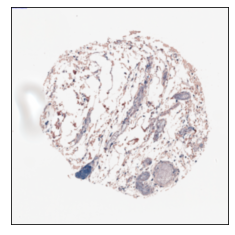

In [20]:
image = cv.imread(f"/root/shared/CNS/Image classification/test/colon/40043_94144_A_8_3.tif")
#plt.imshow(image, interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#plt.show()

image_copy = image.copy()
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = image.unsqueeze(0)
print(image.shape)
outputs = model(image)
_, preds = torch.max(outputs.data, 1)
print(f"Predicted output: {lb.classes_[preds]}")
cv.putText(image_copy, lb.classes_[preds], (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(image_copy, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()




## EfficientNet : Big Bad Boy of Image Classifiers

In [11]:
#!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=cf33455cb9807a861800d0eecb2d9ff8086f1c3def90e376dded835524b0c06e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


### Creating an EfficientNet D0 model

I tried using D4 but again, my machine didn't support it and my kernel died while execution. Had to resort to D0

In [125]:
from efficientnet_pytorch import EfficientNet
#model_eff = EfficientNet.from_pretrained('efficientnet-b0', num_classes=12)

def model_eff(pretrained, requires_grad):
    model_eff = EfficientNet.from_pretrained('efficientnet-b0', num_classes=12)
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model_eff.fc = nn.Linear(2048, len(lb.classes_))
    return model_eff
model_eff = model_eff(pretrained=True, requires_grad=False).to(device)
print(model)

Loaded pretrained weights for efficientnet-b0
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): C

### Defining hyperparameters and settings

In [126]:

lr = 0.001  # Learning rate
num_epochs = 5  # Number of epochs
log_interval = 300  # Number of iterations before logging

# Set loss function (categorical Cross Entropy Loss)
loss_func = nn.CrossEntropyLoss()

# Set optimizer (using Adam as default)
optimizer = optim.Adam(model_eff.parameters(), lr=lr)

### Train and Validationn Functions

In [127]:
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [128]:
#validation function
def validate(model, val_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_dataloader), total=int(len(val_data)/val_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = loss_func(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(val_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(val_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [129]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(5):
    print(f"Epoch {epoch+1} of 5")
    train_epoch_loss, train_epoch_accuracy = fit(model_eff, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model_eff, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1 of 5
Training


28it [07:12, 15.43s/it]                        


Train Loss: 0.0468, Train Acc: 52.41
Validating


10it [01:48, 10.82s/it]                      


Val Loss: 0.0991, Val Acc: 32.76
Epoch 2 of 5
Training


28it [07:13, 15.47s/it]                        


Train Loss: 0.0230, Train Acc: 74.94
Validating


10it [01:50, 11.06s/it]                      


Val Loss: 0.0980, Val Acc: 48.97
Epoch 3 of 5
Training


28it [07:11, 15.40s/it]                        


Train Loss: 0.0201, Train Acc: 79.08
Validating


10it [01:51, 11.13s/it]                      


Val Loss: 0.0531, Val Acc: 55.17
Epoch 4 of 5
Training


28it [07:18, 15.67s/it]                        


Train Loss: 0.0153, Train Acc: 83.10
Validating


10it [01:47, 10.71s/it]                      


Val Loss: 0.0429, Val Acc: 62.76
Epoch 5 of 5
Training


28it [07:00, 15.02s/it]                        


Train Loss: 0.0141, Train Acc: 84.94
Validating


10it [01:47, 10.79s/it]                      

Val Loss: 0.0369, Val Acc: 72.41
45.013 minutes


### Accuracy Plots

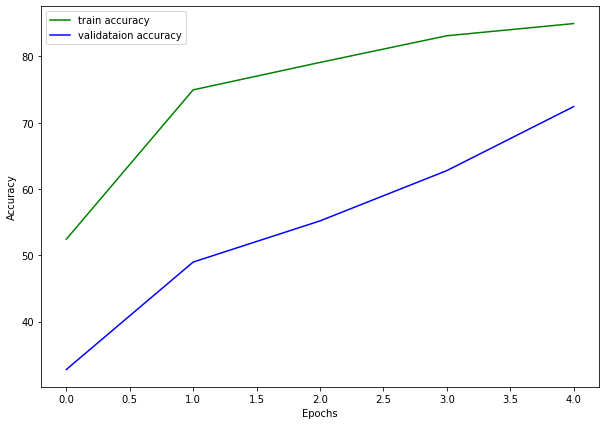

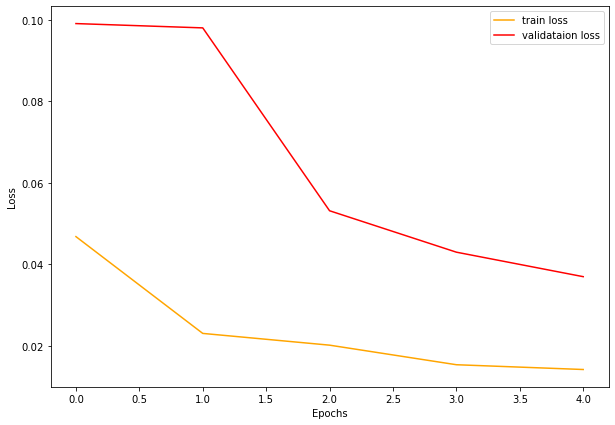

In [130]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('../outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('../outputs/loss.png')
plt.show()

In [134]:
# save the model to disk
print('Saving model...')
torch.save(model_eff.state_dict(), '/root/shared/CNS/model_eff1.pth')

Saving model...


In [135]:
model_eff = EfficientNet.from_pretrained('efficientnet-b0', num_classes=12)
model_eff.load_state_dict(torch.load('/root/shared/CNS/model_eff1.pth'))
print('Model loaded')

Loaded pretrained weights for efficientnet-b0
Model loaded


### Testing

My kernel keeps dying once i execute the below code. i don't have enough computational power probabaly to do the below testing

In [ ]:
image = cv.imread(f"/root/shared/CNS/Image classification/test/colon/40043_94144_A_8_3.tif")
#plt.imshow(image, interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#plt.show()

image_copy = image.copy()
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = image.unsqueeze(0)
print(image.shape)
outputs = model_eff(image)
_, preds = torch.max(outputs.data, 1)
print(f"Predicted output: {lb.classes_[preds]}")
#cv.putText(image_copy, lb.classes_[preds], (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
#plt.imshow(image_copy, interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#plt.show()



torch.Size([1, 3, 3000, 3000])


## HomeGrown CNN

This is a basic model for CNN. The accuracy for this model is very less. I plan to implement Grid Search for HyperParam Tuning or use Talos for Auto Tuning the hyperparams. It will be much much better than this structure. 

In [115]:
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.conv_layer6 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(9216, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        
        out = self.conv_layer5(out)
        out = self.conv_layer6(out)
        out = self.max_pool3(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [116]:
model_cnn = ConvNeuralNet(12)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)  

total_step = len(trainloader)

In [117]:
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [118]:
#validation function
def validate(model, val_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_dataloader), total=int(len(val_data)/val_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = loss_func(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(val_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(val_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [119]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(5):
    print(f"Epoch {epoch+1} of 5")
    train_epoch_loss, train_epoch_accuracy = fit(model_cnn, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model_cnn, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1 of 5
Training


28it [05:35, 12.00s/it]                        


Train Loss: 0.0801, Train Acc: 9.54
Validating


10it [01:49, 10.99s/it]                      


Val Loss: 0.0856, Val Acc: 9.66
Epoch 2 of 5
Training


28it [05:37, 12.06s/it]                        


Train Loss: 0.0799, Train Acc: 12.07
Validating


10it [01:45, 10.53s/it]                      


Val Loss: 0.0855, Val Acc: 11.72
Epoch 3 of 5
Training


28it [05:36, 12.02s/it]                        


Train Loss: 0.0798, Train Acc: 11.61
Validating


10it [01:45, 10.52s/it]                      


Val Loss: 0.0853, Val Acc: 13.10
Epoch 4 of 5
Training


28it [05:31, 11.84s/it]                        


Train Loss: 0.0797, Train Acc: 10.46
Validating


10it [01:40, 10.01s/it]                      


Val Loss: 0.0850, Val Acc: 8.28
Epoch 5 of 5
Training


28it [05:30, 11.80s/it]                        


Train Loss: 0.0794, Train Acc: 10.11
Validating


10it [01:42, 10.23s/it]                      

Val Loss: 0.0844, Val Acc: 8.28
36.581 minutes


# Future Scope of Work

# Something About Me


I might not be the person who has the best notebook or the best predictions but i am a guy who keeps trying and who is passionate about Machine Learning. All i need is a little direction and i will be the best version of myself. I hope you consider me and give me chance to show this to you.

Thank You for this challenge, it was fun. Happy Holidays!!! :)